# Gradient Boosting (Regression)
In this Notebook, an attempt is made to implement a Gradient Boosting model for predicting the time of the next event, based on decision trees. It uses the sklearn Gradient Boosting regressor, which worked quite well for other groups who got an RMSE of < 3 hours with it.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
# Config variables
training_data_path = '../../datasets/bpi_2012_train_eng.csv'
testing_data_path = '../../datasets/bpi_2012_test_eng.csv'

n_samples = -1

params = {
    "n_estimators": 1000,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

# 1. Loading and preparing the data

In [3]:
# Loading and splitting the datasets
df_train = pd.read_csv(training_data_path)
df_train = df_train.set_index('event_index').drop('Unnamed: 0', axis=1)
df_train = df_train.dropna()

df_test = pd.read_csv(testing_data_path)
df_test = df_test.set_index('event_index').drop('Unnamed: 0', axis=1)
df_test = df_test.dropna()


In [4]:
# Make dummy variables from the event type for modelling purposes
event_dummies_train = pd.get_dummies(df_train['event'])
next_event_dummies_train = pd.get_dummies(df_train['nextEvent'])
event_dummies_train = event_dummies_train.join(next_event_dummies_train, lsuffix="_e", rsuffix=("_ne"))

event_dummies_test = pd.get_dummies(df_test['event'])
next_event_dummies_test = pd.get_dummies(df_test['nextEvent'])
event_dummies_test = event_dummies_test.join(next_event_dummies_test, lsuffix="_e", rsuffix=("_ne"))

# Put the dummy variables back in the dataframe as columns
df_train_dummies = pd.concat([df_train, event_dummies_train], axis=1)
df_test_dummies = pd.concat([df_test, event_dummies_test], axis=1)


df_train_dummies.drop(['event', 'nextEvent', 'W_Valideren aanvraag_e', 'W_Valideren aanvraag_ne'], axis=1, inplace=True)
df_test_dummies.drop(['event', 'nextEvent', 'W_Valideren aanvraag_e', 'W_Valideren aanvraag_ne'], axis=1, inplace=True)

# Drop the features the model doesn't use
X_train = df_train_dummies.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'case', 'AMOUNT_REQ', 'org:resource', 'nextEventTime', 'nextEventTimeRel'])
X_test = df_test_dummies.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'case', 'AMOUNT_REQ', 'org:resource', 'nextEventTime', 'nextEventTimeRel'])

# Construct the output parameters with from the training and testing sets with the correct rows dropped
Y_train = df_train_dummies['nextEventTimeRel']
Y_test = df_test_dummies['nextEventTimeRel']

X_train.head()


,startTimeRel,indexInCase,dayOfWeek,dayOfMonth,A_ACCEPTED_e,A_ACTIVATED_e,A_APPROVED_e,A_CANCELLED_e,A_DECLINED_e,A_FINALIZED_e,A_PARTLYSUBMITTED_e,A_PREACCEPTED_e,A_REGISTERED_e,A_SUBMITTED,O_ACCEPTED_e,O_CANCELLED_e,O_CREATED_e,O_DECLINED_e,O_SELECTED_e,O_SENT_e,O_SENT_BACK_e,W_Afhandelen leads_e,W_Beoordelen fraude_e,W_Completeren aanvraag_e,W_Nabellen incomplete dossiers_e,W_Nabellen offertes_e,A_ACCEPTED_ne,A_ACTIVATED_ne,A_APPROVED_ne,A_CANCELLED_ne,A_DECLINED_ne,A_FINALIZED_ne,A_PARTLYSUBMITTED_ne,A_PREACCEPTED_ne,A_REGISTERED_ne,O_ACCEPTED_ne,O_CANCELLED_ne,O_CREATED_ne,O_DECLINED_ne,O_SELECTED_ne,O_SENT_ne,O_SENT_BACK_ne,W_Afhandelen leads_ne,W_Beoordelen fraude_ne,W_Completeren aanvraag_ne,W_Nabellen incomplete dossiers_ne,W_Nabellen offertes_ne
event_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48289,1375482,15,4,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
101208,0,0,4,23,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51064,0,1,3,10,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77689,932113,12,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
102277,0,1,0,26,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# 2. Training the model and making the predictions

In [5]:
from sklearn.metrics import mean_squared_error
import time
start_time = time.time()

# Creating and fitting the model
xgbr = GradientBoostingRegressor(**params)
xgbr.fit(X_train, Y_train)

# Predicting the values of our test dataset
xgbr_pred = xgbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, xgbr_pred))

# Retrieving the accuracy of the model
print(f'RMSE score: {rmse}')

# Ending time
end_time = time.time()
print(f'\r\nThe execution of Gradient Boosting (Regression) took {round(end_time - start_time)} seconds')

RMSE score: 371196.1658541116

The execution of Gradient Boosting (Regression) took 149 seconds


# 3. Applying to Housing dataset

Since the resulting RMSE score of applying Gradient Boosting to the BPI dataset is still quite bad, it's important that we check whether the model has been implemented incorrectly or whether the issue is in the feature selection/engineering. To that end, the next blocks apply the same Gradient Boosting regressor model to another dataset, the Boston housing dataset, to check the performance.

In [6]:
# Load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df_housing = pd.read_csv(url, header=None)

# Summarize shape
display(df_housing.shape)

# Summarize first few lines
display(df_housing.head())

(506, 14)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [7]:
# Split data into input and output columns
from sklearn.model_selection import train_test_split
X, y = df_housing.iloc[:, :-1], df_housing.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

In [8]:
from sklearn.metrics import mean_squared_error
import time
start_time = time.time()

# Creating and fitting the model
xgbr_housing = GradientBoostingRegressor(**params)
xgbr_housing.fit(X_train, y_train)

# Predicting the values of our test dataset
xgbr_housing_pred = xgbr_housing.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgbr_housing_pred))

# Retrieving the accuracy of the model
print(f'RMSE score: {rmse}')

# Ending time
end_time = time.time()
print(f'\r\nThe execution of Gradient Boosting (Regression) for Housing took {round(end_time - start_time)} seconds')

RMSE score: 3.3172937380949277

The execution of Gradient Boosting (Regression) for Housing took 2 seconds


The resulting RMSE score for the Housing dataset is rather decent. The RMSE for the naive baseline for this set comes in at around 6.6, and other sources on the internet ([Kaggle](https://www.kaggle.com/code/tolgahancepel/boston-housing-regression-analysis/notebook)) also show that it ranks close to a lot of other machine learning models like Random Forest, Linear Regression and Support Vector Regression.

We can thus conclude that the issue lies not with the model, but with the feature engineering on the BPI dataset.

# 3. Re-attempt at feature engineering

In [9]:
# Loading and splitting the datasets
df_train = pd.read_csv(training_data_path)
df_train = df_train.set_index('event_index').drop('Unnamed: 0', axis=1).sort_values(['case', 'startTime'], ascending=[True, True])
df_train = df_train.dropna()

df_test = pd.read_csv(testing_data_path)
df_test = df_test.set_index('event_index').drop('Unnamed: 0', axis=1).sort_values(['case', 'startTime'], ascending=[True, True])
df_test = df_test.dropna()


In [10]:
# Make dummy variables from the current event type for modelling purposes
event_dummies_train = pd.get_dummies(df_train['event'])
event_dummies_test = pd.get_dummies(df_test['event'])

# Put the dummy variables back in the dataframe as columns
df_train_dummies = pd.concat([df_train, event_dummies_train.add_suffix('_e')], axis=1)
df_test_dummies = pd.concat([df_test, event_dummies_test.add_suffix('_e')], axis=1)

In [11]:
# Add empty columns for the event types in both the training- and testing dataset
train_event_types = df_train['event'].unique()
test_event_types = df_test['event'].unique()

event_types = pd.concat([pd.Series(train_event_types), pd.Series(test_event_types)]).unique()

def add_occurred_events_per_case(df):
    for ev in event_types:
        df[ev] = 0
    
    # Construct a list of case IDs
    case_ids = df['case'].unique()

    for case_index in case_ids:
        # Construct occurance list
        case_events = []
        for ev_index in df[df['case'] == case_index].T:
            case_events.append(df.loc[ev_index, 'event'])
        
        # Constructed occurance list, now add them to the rows of the case
        for (ev_index_in_case, ev_index) in enumerate(df[df['case'] == case_index].T):
            occurred_events = case_events[0:ev_index_in_case]
            
            for evType in occurred_events:
                df.loc[ev_index, evType] = 1
    
    return df

df_train_traced = add_occurred_events_per_case(df_train_dummies)
df_test_traced = add_occurred_events_per_case(df_test_dummies)

In [12]:
df_train_traced.head(25)

,case,event,startTime,completeTime,AMOUNT_REQ,REG_DATE,org:resource,nextEvent,nextEventTime,nextEventTimeRel,startTimeRel,indexInCase,dayOfWeek,dayOfMonth,A_ACCEPTED_e,A_ACTIVATED_e,A_APPROVED_e,A_CANCELLED_e,A_DECLINED_e,A_FINALIZED_e,A_PARTLYSUBMITTED_e,A_PREACCEPTED_e,A_REGISTERED_e,A_SUBMITTED_e,O_ACCEPTED_e,O_CANCELLED_e,O_CREATED_e,O_DECLINED_e,O_SELECTED_e,O_SENT_e,O_SENT_BACK_e,W_Afhandelen leads_e,W_Beoordelen fraude_e,W_Completeren aanvraag_e,W_Nabellen incomplete dossiers_e,W_Nabellen offertes_e,W_Valideren aanvraag_e,A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Completeren aanvraag,A_ACCEPTED,O_SELECTED,O_CREATED,O_SENT,W_Nabellen offertes,O_SENT_BACK,W_Valideren aanvraag,A_FINALIZED,O_CANCELLED,O_ACCEPTED,A_REGISTERED,A_APPROVED,W_Afhandelen leads,A_DECLINED,W_Nabellen incomplete dossiers,A_ACTIVATED,O_DECLINED,W_Beoordelen fraude,A_CANCELLED
event_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,173688,A_SUBMITTED,2011/10/01 00:38:44.546,2011/10/01 00:38:44.546,20000,2011/10/01 00:38:44.546,112,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,0.0,0,0,5,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,173688,A_PARTLYSUBMITTED,2011/10/01 00:38:44.880,2011/10/01 00:38:44.880,20000,2011/10/01 00:38:44.546,112,A_PREACCEPTED,2011-10-01 00:39:37.906,53.0,0,1,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,173688,A_PREACCEPTED,2011/10/01 00:39:37.906,2011/10/01 00:39:37.906,20000,2011/10/01 00:38:44.546,112,W_Completeren aanvraag,2011-10-01 11:36:46.437,39429.0,53,3,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,173688,A_PREACCEPTED,2011/10/01 00:39:37.906,2011/10/01 00:39:37.906,20000,2011/10/01 00:38:44.546,112,A_PREACCEPTED,2011-10-01 00:39:37.906,0.0,53,2,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,173688,W_Completeren aanvraag,2011/10/01 11:36:46.437,2011/10/01 11:45:13.917,20000,2011/10/01 00:38:44.546,112,A_ACCEPTED,2011-10-01 11:42:43.308,357.0,39482,4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,173688,A_ACCEPTED,2011/10/01 11:42:43.308,2011/10/01 11:42:43.308,20000,2011/10/01 00:38:44.546,10862,O_SELECTED,2011-10-01 11:45:09.243,146.0,39839,5,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,173688,O_SELECTED,2011/10/01 11:45:09.243,2011/10/01 11:45:09.243,20000,2011/10/01 00:38:44.546,10862,A_FINALIZED,2011-10-01 11:45:11.197,2.0,39985,6,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,173688,O_CREATED,2011/10/01 11:45:11.197,2011/10/01 11:45:11.197,20000,2011/10/01 00:38:44.546,10862,O_SENT,2011-10-01 11:45:11.380,0.0,39987,7,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,173688,O_SENT,2011/10/01 11:45:11.380,2011/10/01 11:45:11.380,20000,2011/10/01 00:38:44.546,10862,W_Nabellen offertes,2011-10-01 12:15:41.290,1830.0,39987,8,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
def add_prev_events_per_case(df):
    df_new = df.copy()
    df_new['prev_event'] = df['event'].shift(1)
    df_new['prev_prev_event'] = df['event'].shift(2)

    # For validation's sake (removing prev events from other traces)
    df_new['prev_case'] = df['case'].shift(1)
    df_new['prev_prev_case'] = df['case'].shift(2)


    for row, value in df_new.iterrows():
        if (value['case'] != value['prev_case']):
            df_new.loc[row, 'prev_event'] = 'NaE'
        if (value['case'] != value['prev_prev_case']):
            df_new.loc[row, 'prev_prev_event'] = 'NaE'
    
    # Make dummy variables from the new columns
    prev_event_dummies = pd.get_dummies(df_new['prev_event'])
    prev_prev_event_dummies = pd.get_dummies(df_new['prev_prev_event'])

    # Put the dummy variables back in the dataframe as columns
    df_prev_dummies = pd.concat([df_new, prev_event_dummies.add_suffix('_prev')], axis=1)
    df_prev_prev_dummies = pd.concat([df_prev_dummies, prev_prev_event_dummies.add_suffix('_prev_prev')], axis=1)

    df_prev_prev_dummies.drop(columns=['prev_case', 'prev_prev_case', 'prev_event', 'prev_prev_event'])

    return df_prev_prev_dummies

df_train_traced_prev = add_prev_events_per_case(df_train_traced)
df_test_traced_prev = add_prev_events_per_case(df_test_traced)

In [42]:
df_train_prepped = df_train_traced_prev.drop(columns=['event', 'nextEvent', 'W_Valideren aanvraag_e', 'W_Valideren aanvraag', 'prev_event', 'prev_prev_event', 'prev_case', 'prev_prev_case'])
df_test_prepped = df_test_traced_prev.drop(columns=['event', 'nextEvent', 'W_Valideren aanvraag_e', 'W_Valideren aanvraag', 'prev_event', 'prev_prev_event', 'prev_case', 'prev_prev_case'])

# Drop the features the model doesn't use
X_train = df_train_prepped.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'case', 'AMOUNT_REQ', 'org:resource', 'nextEventTime', 'nextEventTimeRel'])
X_test = df_test_prepped.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'case', 'AMOUNT_REQ', 'org:resource', 'nextEventTime', 'nextEventTimeRel'])

# Construct the output parameters with from the training and testing sets with the correct rows dropped
Y_train = df_train_prepped['nextEventTimeRel']
Y_test = df_test_prepped['nextEventTimeRel']

X_train_idx = X_train.index
X_train_col = X_train.columns

# Scaling all features
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.fit_transform(X_test)


#df_train_scaled_features = pd.DataFrame(X_train, index=X_train_idx, columns=X_train_col)

#df_train_scaled_features.head()

# 4. Running the model on the new data

In [34]:
from sklearn.metrics import mean_squared_error
import time
start_time = time.time()

# Creating and fitting the model
xgbr = GradientBoostingRegressor(**params)
xgbr.fit(X_train, Y_train)

# Predicting the values of our test dataset
xgbr_pred = xgbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, xgbr_pred))

# Retrieving the accuracy of the model
print(f'RMSE score: {rmse}')

# Ending time
end_time = time.time()
print(f'\r\nThe execution of Gradient Boosting (Regression) took {round(end_time - start_time)} seconds')

RMSE score: 373910.5020997637

The execution of Gradient Boosting (Regression) took 173 seconds


# 5. Comparison: Regression using RFR

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time

start_time = time.time()

rfr = RandomForestRegressor(random_state=42, max_depth=12, min_samples_split=4)
rfr.fit(X_train, Y_train)

# Predicting the values of our test dataset
rfr_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(Y_test, rfr_pred))

# Retrieving the accuracy of the model
print(f'RMSE score: {rmse}')

# Ending time
end_time = time.time()
print(f'\r\nThe execution of Random Forest (Regression) took {round(end_time - start_time)} seconds')


C:\Users\20203477\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A_CANCELLED_prev_prev
Feature names seen at fit time, yet now missing:
- A_REGISTERED_prev_prev

  warnings.warn(message, FutureWarning)


RMSE score: 370749.31687584694

The execution of Random Forest (Regression) took 32 seconds


## 5.2 Constructing feature importance

Elapsed time to compute the importances: 0.016 seconds


Text(0, 0.5, 'Mean decrease in impurity')

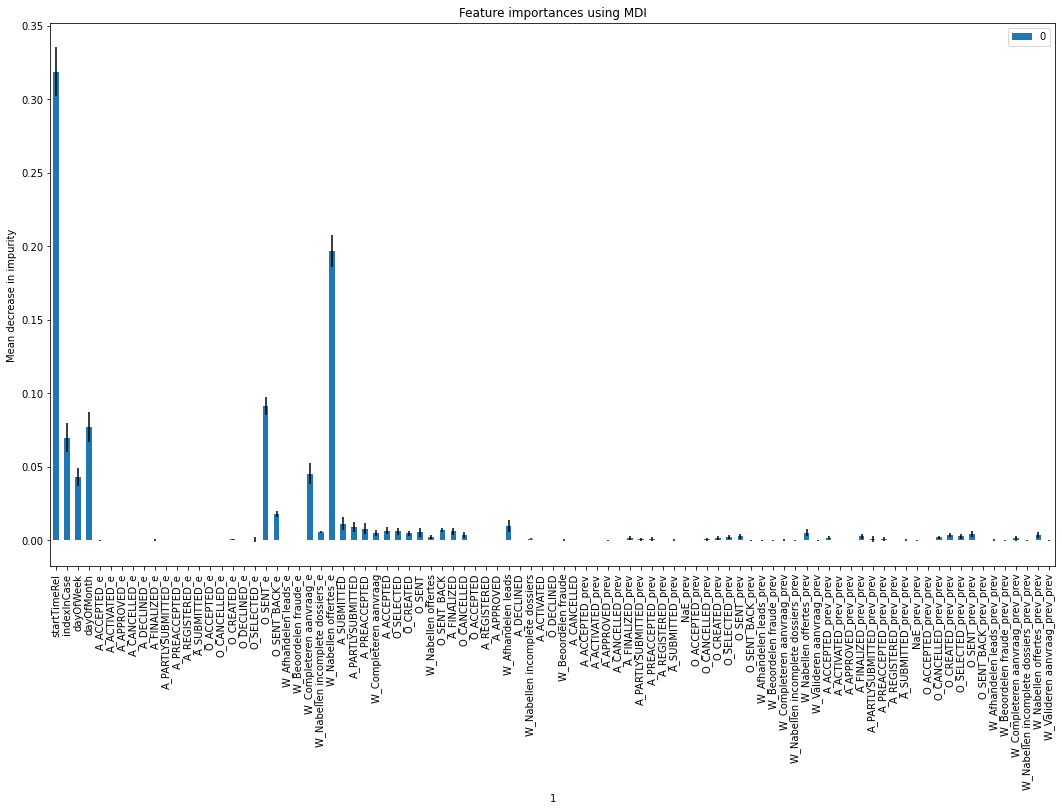

In [44]:
start_time = time.time()
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

import pandas as pd

forest_importances = pd.Series(importances)
df_importances = pd.concat([forest_importances, pd.Series(X_train_col)], axis=1)

fig, ax = plt.subplots()
df_importances.plot.bar(yerr=std, ax=ax, x=1, y=0, figsize=(18, 10))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


# Results Listing


| Model | Features | RMSE (seconds) | RMSE (days)  |
|---|---|---|---|
| Random Forest Regressor | Current event | 390.000 | 4.5d |
| Random Forest Regressor | Current event, next event | 384.153 | 4.4d |
| Random Forest Regressor | Current event, next event | 384.153 | 4.4d |
| Random Forest Regressor | Current event, next event, day of week, day of month | 368.956 | 4.27d |
| Random Forest Regressor (Predicting train) | Current event, next event, day of week, day of month | 163.771 | 1.8d |

\\

| Model | Features | RMSE (seconds) | RMSE (days)  |
|---|---|---|---|
| RFR | Current event, day of week, day of month, startTimeRel, indexInCase, next event | 371k | 4.3d |
| RFR | Current event, day of week, day of month, startTimeRel, indexInCase, events in trace | 369k | 4.4d |
| GBT | Current event, day of week, day of month, startTimeRel, indexInCase, events in trace | 374k | 4.4d |
| RFR | Current event, day of week, day of month, startTimeRel, indexInCase, events in trace, prev, prev_prev | 370k | 4.4d |
| GBT | Current event, day of week, day of month, startTimeRel, indexInCase, events in trace, prev, prev_prev | 373k | 4.4d |